In [ ]:
import pandas as pd   
import numpy as np
from pandas.util._decorators import Appender    #importing libraries for working with dataframes and the fbprophet itself 
import matplotlib.pyplot as plt
from fbprophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

# **The Prophet Forecasting Model - Time Series Forecasting**


In this tutorial we are going to introduce Prophet, a python library for time series forecasting. We will briefly discuss the theory behind it, provide a coding example, discuss model's advantages and disadvantages and compare it with a SARIMAX model.

Strap in!

## **What is this?**

The Prophet is a time series forecasting model designed to handle the *common features* of business time series.

So, we could define such characteristics as:
- hourly, daily, or weekly observations with at least a few months (preferably a year) of history
- strong multiple “human-scale” seasonalities: day of week and time of year
- important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
- a reasonable number of missing observations or large outliers
- historical trend changes, for instance due to product launches or logging changes
- trends that are non-linear growth curves, where a trend hits a natural limit or saturates

## **How it works**

At its core, the Prophet procedure is *an additive regression model* with four main components:
1. A piecewise linear or logistic growth curve trend. Prophet automatically 
detects changes in trends by selecting changepoints from the data.
2. A yearly seasonal component modeled using Fourier series.
3. A weekly seasonal component using dummy variables.
4. A user-provided list of important holidays.

### **The Math behind the Prophecy**
Trying to describe the model throughout mathematical language, we can get a formula: 

$$y(t)=g(t)+s(t)+h(t)+\varepsilon_{t}$$

where \
$\textbf{g(t)}$ - is the trend function which models non-periodic changes in the value of the time  series, where the function is a piecewise linear or logistic function. The logistic function of the form $g(t)=\frac{C}{1+\exp (-k(t-b))}$  allows you to simulate growth with saturation, when with an increase in the indicator, its growth rate decreases; 

$\textbf{s(t)}$  - represents  periodic  changes (e.g.  weekly  and  yearly  seasonality), implemented through a dummy variable. Seasonal effects $s(t)$ are approximated by the following function:
$$
s(t)=\sum_{n=1}^{N}\left(a_{n} \cos \left(\frac{2 \pi n t}{P}\right)+b_{n} \sin \left(\frac{2 \pi n t}{P}\right)\right)
$$
$\mathrm{P}$ is the period $(365.25$ for yearly data and 7 for weekly data)
Parameters $\left[a_{1}, b_{1}, \ldots \ldots, a_{N}, b_{N}\right]$ need to be estimated for a given $N$ to model seasonality;

$\textbf{h(t)}$  - represents the effects of holidays which occur on potentially irregular schedules overone or more days (e.g. Black Fridays);

$\varepsilon_{t}$ - represents an error and any idiosyncratic changes which are not accommodated  by  the  model.

###**Coding is Magic**

Prophet is designed to perform the majority of necessary adjustments automatically, but allows for some customization. 

Essentially, to perform a model fitting and make a forecast one has to properly label the data, create a model as an instance of a built-in `Prophet()` class and call fitting and predicting functions. It is way less work than is needed for, for example, a SARIMAX implementation, if a process is non-stationary and needs severe adjustments. Prophet also provides some visualization tools to examine model’s performance. 

Let’s proceed with a coding example.


## **Code tutorial**

**Fitting a simple model using Prophet**

In this tutorial we will work with a dataset containing monthly temperature measurements taken between November 1st, 1743 and September 1st, 2013 in a variety of countries, specifically with a subset containing observations taken in Russia.

We load the data, extract the Russian subset and plot the observations taken  between 1.1.1970 and 1.1.2000 with `pyplot` to get a look at the data structure before proceeding with Prophet forecasting.

In [ ]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv', sep=",",index_col='dt', parse_dates=True)
df.head()

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1743-11-01,4.384,2.294,Åland
1743-12-01,NaN,NaN,Åland
1744-01-01,NaN,NaN,Åland
1744-02-01,NaN,NaN,Åland
1744-03-01,NaN,NaN,Åland


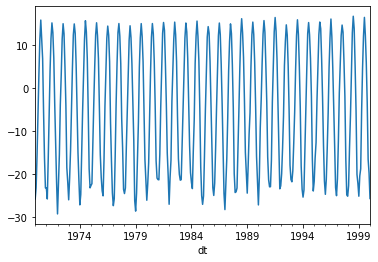

In [ ]:
df_Russia = df.loc[df['Country'] == 'Russia']
df_Russia.columns = ['y', 'AverageTemperatureUncertainty', 'Country']
df_Russia = df_Russia[df_Russia.y.isnull() == False] 

fig, ax = plt.subplots()
df_Russia['y']['1970-1-1':'2000-1-1'].plot(ax=ax)
plt.show()

As expected, the graph shows a strong yearly seasonality and a slight upward trend due to global warming. 

Prophet requires data to be stored as a `pandas DataFrame()` object, the first column being the date (named ‘ds’, containing `pandas date-times`), the second being the observed responses (named ‘y’). We duplicate the index as a column of dates to simultaniously satisfy Prophet's prerequisits and still be able to use the index for `matplotlib` operations.

In [ ]:
df_Russia.insert(3,'ds', df_Russia.index, True)
df_Russia.head()

,y,AverageTemperatureUncertainty,Country,ds
dt,,,,
1812-01-01,-27.114,4.336,Russia,1812-01-01
1812-02-01,-25.644,4.394,Russia,1812-02-01
1812-03-01,-19.108,4.171,Russia,1812-03-01
1812-04-01,-7.605,4.286,Russia,1812-04-01
1812-05-01,2.296,3.594,Russia,1812-05-01


To make a Prophet forecast, first create a model as a `Prophet()` object; it can take additional arguments for manual tuning, such as growth type, seasonality, trend change points etc., but by default the model will try to figure out all necessary features by itself.

Apply a `.fit()` function passing it the data and the model is ready to go.


In [ ]:
m = Prophet()
m.fit(df_Russia[['ds','y']]['1910-1-1':'2013-9-1'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


To perform a prediction, create a data frame of future dates to predict. It can be accomplished with Prophet’s `make_future_dataframe()` method; it takes the number of points to generate and their frequency as arguments. In this example, 48 points are generated with monthly frequency, which is equivalent to 4 years. Another possible values for the frequency argument `freq` include: "day", "week",  "quarter", "year", 1 (1 sec), 60 (1 minute) or 3600 (1 hour). It is important to choose the proper frequency because the model is continious-time and you may get dubious results if, for example, you have monthly data and try to predict the daily values (as set by default).

To make a forecast, apply a `.predict()` function to the model and pass it the future data frame. 

Prophet has a few visualization tools. First, `.plot()` provides an overview of the forecast (points represent observations):


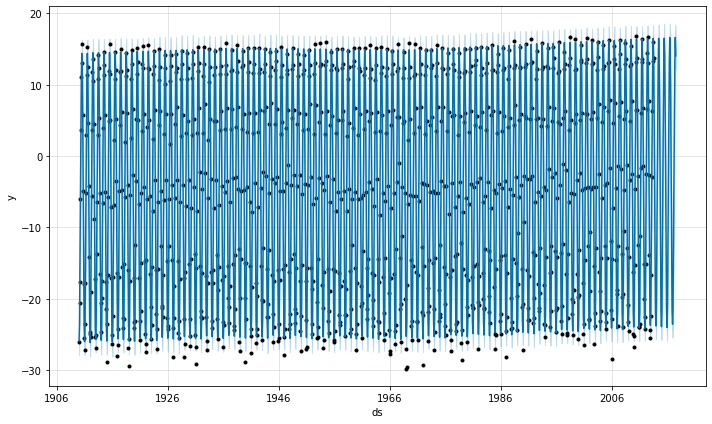

In [ ]:
future = m.make_future_dataframe(periods=48, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

Due to an overly huge number of observations the graph is not particularly visually coherent. Unfortunately, the function takes the historical data strate from the model, so we find that the most convinient workaround is to set up a separate model trained on a smaller sample of the historical data and plot a sample from the complete model's forecast alongside its historical points:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


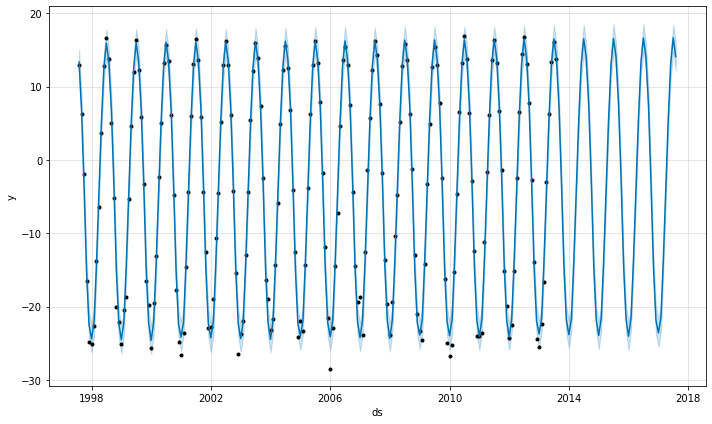

In [ ]:
m1 = Prophet()
m1.fit(df_Russia[['ds','y']]['1997-08-01':'2017-08-01'])
fig = m1.plot(forecast[1051:1292])

It is evident now that the forecast fits quite well with the historical data. Seasonalities are also consistents, and as for the overall upward trend - it is more visible on the previous, more dense version of the plot.

Another plotting method, `.plot_components()`, plots the features separately: trend, seasonality, and abnormal dates if provided (such as holidays or Black Fridays)

Those can be provided as arguments of the model’s `Prophet()` object; customization possibilities include linear/logistic trend setting, change points management, seasonality management, holidays specification and uncertainty estimation tuning. More information is provided below.


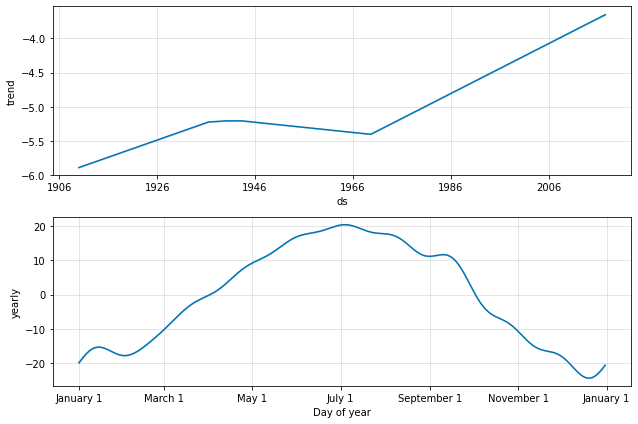

In [ ]:
fig_components = m.plot_components(forecast) 

There is a steady upward trend consistent with the global warming theory and the historical data provided; average changes during the course of a year also seem reasonable, a spike between September and October can perhaps be explained by the Indian summer fenomenon.

**Modelling holidays**

To include holidays in your model, you have to create a separate dataframe for them. It must have 2 columns ("holiday" and "ds") and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data goes) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns "lower_window" and "upper_window" that will extend the holiday out to [lower_window, upper_window] days around the date. 

Once the table is created, holiday effects are included in the forecast by passing them to the holidays argument:

In [ ]:
holidays_df = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

m = Prophet(holidays = holidays_df)

The holiday effects will also show up in the components plot as a separate graph with spikes on the days around the holiday.

A Prophet model also has several built-in sets of country holidays which can be added to the model by the `add_country_holidays` function:

In [ ]:
m.add_country_holidays(country_name = 'RU')

If the model ends up overfitting holidays, `Prophet()` parameter `holidays_prior_scale` can adjust the "liberties" the model takes while forecasting them. It is set to 10 by default, which allows for very small regularization, so turning it down will help reduce the effect of the holidays:

In [ ]:
m = Prophet(holidays = holidays, holidays_prior_scale = 0.05).fit(df)

You can adjust the scale separately for different holidays by adding a respective column to the holidays data frame. It is also possible to specify it for different seasonalities using `add_seasonality`'s `prior_scale` parameter:

In [ ]:
m = Prophet()
m.add_seasonality(name = 'weekly', period = 7, fourier_order = 3, prior_scale = 0.1)

**Specifying seasonalities**

Prophet will try to fit weekly and yearly seasonalities by default if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method.

The function takes the seasonality's name, period in days, and the Fourier order for it as arguments. For example, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. 

You canalso exclude unnecessary seasonalities by specifying the parameters of the model. The examples of the code are below:

In [ ]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)

It is possible to tune more complex seasonalities, e. g. weekdays vs. weekends patterns or weekly patterns that depend on seasons via conditional seasonalities.

For example, we expect weekly seasonality that has different patterns in spring-summer time and fall-winter time. A possible solution is to create a dummy variable and respective coluns to distinguish the seasons:

In [ ]:
def hot_or_cold(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 3)

df['cold'] = df['ds'].apply(hot_or_cold)
df['hot'] = ~df['ds'].apply(hot_or_cold)

And then exclude the default weekly seasonality and add a separate weekly seasonality per season:

In [ ]:
m = Prophet(weekly_seasonality = False)
m.add_seasonality(name = 'weekly_cold', period = 7, fourier_order = 3, condition_name = 'cold')
m.add_seasonality(name = 'weekly_hot', period = 7, fourier_order = 3, condition_name = 'hot')

**Adding regressors**

You can add regressors to the linear part of the model via the `add_regressor` method. It is important that you include the column specifying the reressor's values to both historical and future data frames.

For example, let's model the hot season/cold season situation that we used to specify different weekly seasonalities throughout the year as a regressor now:

In [ ]:
def hot_or_cold(ds):
    date = pd.to_datetime(ds)
    if date.month > 8 or date.month < 3:
      return 1
    else:
      return 0

df['hot_or_cold'] = df['ds'].apply(hot_or_cold)

m = Prophet()
m.add_regressor('hot_or_cold')
m.fit(df)

future['hot_or_cold'] = future['ds'].apply(hot_or_cold)

forecast = m.predict(future)

Note that the regressor has to be known for the future dates as well as for the historical ones. Prophet will also raise an error if the regressor is constant throughout the historical data.

The values of beta coefficients for added regressors can be extracted via `regressor_coefficients` function: 

In [ ]:
from fbprophet.utilities import regressor_coefficients

regressor_df = regressor_coefficients(m)

## **Assesment of model quality**


**Assessing the quality of the model on previous data and with a different model**\
Let's check the quality of our model. To do this, we will temporarily delete the data from 01.10.2000 to 01.09.2013 and predict it using our model. Then we will calculate the MAE to check how close the predictions are. 
In the code below we fit the model and visualise the results.
 

Fit the model as before, base it on data with excluded 2000-2013 time period.

In [ ]:
quality_test_model = Prophet()
quality_test_model.fit(df_Russia[['ds','y']]['1950-1-1':'2000-9-1'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


We construct a data frame for future points, including the test data, and make a forecast. We also plot the forecast alongside the historical data, both full and spaced out versions (using the workaround), to visually assess the accuracy of the prediction.

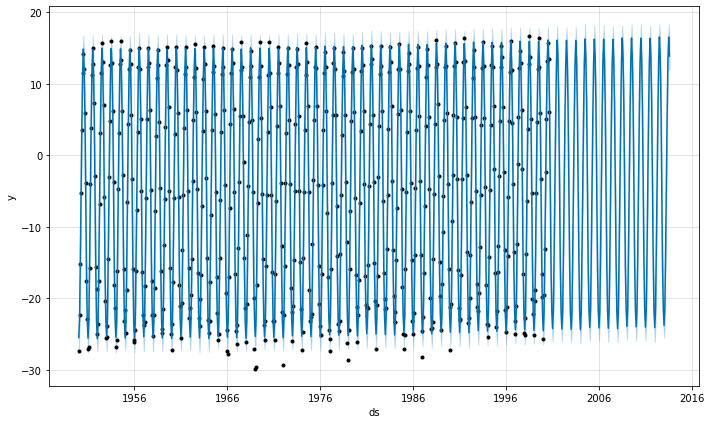

In [ ]:
future = quality_test_model.make_future_dataframe(periods=155, freq='MS')
fcst = quality_test_model.predict(future)
fig = quality_test_model.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


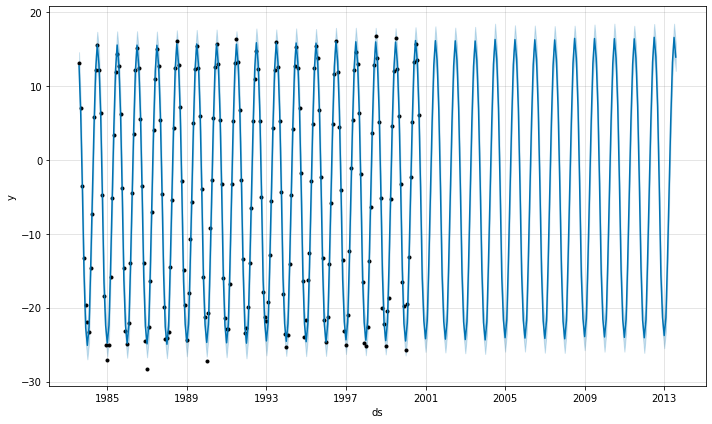

In [ ]:
m1 = Prophet()
m1.fit(df_Russia[['ds','y']]['1983-08-01':'2000-9-1'])
fig = m1.plot(fcst[403:764])

It seems that the model makes a reasonably good forecast, though it tends to underfit extremely low temperatures around New Years.

To calculate accuracy measures, add the forecasted responses to the true responses data frame.

In [ ]:
forecasted_df = fcst.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_Russia.set_index('ds')) 

And plot the results for visual comparison:

In [ ]:
def show_forecast(forecasted_df, true_values, num_predictions, num_values):
    #forecast
    forecast = go.Scatter(
        name = 'Prediction',
        x = forecasted_df.tail(num_predictions).index,
        y = forecasted_df.tail(num_predictions).yhat,
        mode = 'lines',
        line = dict(color = 'rgb(31, 119, 180)'),
    )

    # upper bond of prediction interval
    upper_bound = go.Scatter(
        name = 'Upper Bound',
        x = forecasted_df.tail(num_predictions).index,
        y = forecasted_df.tail(num_predictions).yhat_upper,
        mode = 'lines',
        marker = dict(color="blue"),
        line = dict(width=0),
        fillcolor = 'rgba(68, 68, 68, 0.3)',
        fill = 'tonexty')

  
    # lower part of prediction interval
    lower_bound = go.Scatter(
        name = 'Lower Bound',
        x = forecasted_df.tail(num_predictions).index,
        y = forecasted_df.tail(num_predictions).yhat_lower,
        marker = dict(color="green"),
        line = dict(width = 0),
        mode ='lines')

    # true values
    fact = go.Scatter(
        name = 'Fact',
        x = true_values.tail(num_values).index,
        y = true_values.tail(num_values).y,
        marker = dict(color="red"),
        mode = 'lines',
    )

    data = [lower_bound, upper_bound, fact, forecast]

    layout = go.Layout(
        yaxis = dict(title='Average tempeature'),
        showlegend = True,
        width = 900, height = 500)

    fig = go.Figure(data = data, layout = layout)
    iplot(fig, show_link = False)


In [ ]:
show_forecast(forecasted_df, forecasted_df, 155, 200)

In the graph above we plotted the tails of real and predicted data. We can see that the Prophet model follows the true observations closely. 

Now let's check the precision using MAE (mean absolute error) and MAPE (mean absolute percent error).



`MAPE (mean absolute percentage error)` - this is the mean absolute error of our forecast. Let $y_i$ - this is an indicator, and $\hat y_i$ - this is the forecast of our model corresponding to this value. Then $e_i = y_i - \hat y_i$ is the forecast error, and $p_i = \frac{e_{i}}{y_{i}}$ is the relative forecast error.
$$M A P E=\operatorname{mean}\left(\left|p_{i}\right|\right)$$

`MAE (mean absolute error)` - this is the absolute error of our forecast. It is used to see how much the model is wrong in absolute terms.

$$M A E=\operatorname{mean}\left(\left|e_{i}\right|\right)$$

Calculating MAE, MAPE and making coclusions:

In [ ]:
forecasted_df['e'] = forecasted_df['y'] - forecasted_df['yhat']
forecasted_df['p'] = 100*forecasted_df['e']/forecasted_df['y']

print( 'MAPE: ', np.mean(abs(forecasted_df[-155:]['p'])), '%')
print('MAE', np.mean(abs(forecasted_df[-155:]['e'])))

MAPE:  14.62575647917587 %
MAE 1.167400301831763


We get that on average the forecasted value is off from the true value by 14.63% or by approximately 1.167 degrees which means that the model's quality is quite good.

**Comparison with SARIMAX**

We also want to know whether our model is good in comparison with others. We want to test it against the SARIMAX model.

Steps:
1. Fit the SARIMAX model on the dataframe without the last 13 years.
2. Predict the last 13 years using SARIMAX
3. Compare the prediction's quality by MAE and MAPE.

First we generate a SARIMAX model via the `auto_arima()` method, fit the historical data sans 2000-2013 observations and make a prediction, calculating the prediction interval along the way:

In [ ]:
#generating sarimax model
sarimax_model = pm.auto_arima(df_Russia['y'])
model = sarimax_model.fit(df_Russia['y']['1950-1-1':'2000-9-1']) #подбираем модель, фиттим нужные данные
future_forecast = model.predict(n_periods = 155, return_conf_int = True, alpha = 0.05) #предсказываем вместе с prediction interval

Then create a data frame to plot the prediction:

In [ ]:
forecast = pd.DataFrame(data = future_forecast[0], index = test.index, columns = ['yhat'])

conf_start = []
conf_end = []
for i in future_forecast[1]:
  conf_start.append(i[0])
  conf_end.append(i[1])
forecast.insert(1, 'yhat_lower', conf_start)
forecast.insert(2, 'yhat_upper', conf_end)

In [ ]:
show_forecast(forecast, df_Russia[['y']],  155, 200)

Visually it seems pretty close to the Prophet's result, even if the prediction intervals look a bit wider.

Let's calculate MAE and MAPE for SARIMAX to get a better grasp on which model did better.

In [ ]:
true_y_values_tail = df_Russia[['y']][-155:]

forecast['e'] = true_y_values_tail['y'] - forecast['yhat']
forecast['p'] = 100*forecast['e']/true_y_values_tail['y']

print( 'MAPE: ', np.mean(abs(forecast[-155:]['p'])), '%')
print('MAE', np.mean(abs(forecast[-155:]['e'])))

MAPE:  25.55688685553109 %
MAE 1.6466225731116368


On our data the SARIMAX model's predictions are off by 25.6% on average or by 1.64 degrees. This means that the default Prophet model produced better results than the SARIMAX model. Besides, auto SARIMAX models usually require more computational power and time because they need to fit many parameters every time, epecially when working with larger datasets.

Still we can't make an incontrovertible conclusion that the Prophet model is always better than SARIMAX. There may be cases when the exact parameters of a SARIMAX model are known or when the auto function just gives better overall results that Prophet.

This experiment, however, showes that Prophet is a user-friendly and powerfull library for forecasting time-series which can be used in line with more classical tools like SARIMAX class of models.